<a href="https://colab.research.google.com/github/msommerfe/CAS_Applied_Data_Science/blob/main/CAS_Final_Project/OCR_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import cv2
import os

In [1]:
try:
  from google.colab import drive
  import os
  drive.mount('/content/drive')
  data_dir = 'drive/My Drive/colab/keras-ocr'
  os.makedirs(data_dir, exist_ok=True)
except ImportError:
  data_dir = '.'

Mounted at /content/drive


In [ ]:
### Converting CHars to nums is better for ML

alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' 0123456789"
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels
batch_size = 128

def label_to_num(label):
    label_num = []
    for ch in label:

            label_num.append(alphabets.find(ch) if alphabets.find(ch)!=-1 else alphabets.find('-'))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret



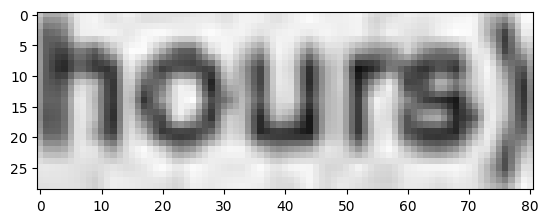

array([[195, 169, 170, ..., 222, 248, 250],
       [179, 143, 146, ..., 213, 248, 249],
       [166, 123, 127, ..., 199, 241, 241],
       ...,
       [229, 230, 229, ..., 193, 232, 228],
       [227, 228, 228, ..., 209, 242, 235],
       [225, 225, 226, ..., 222, 248, 239]], dtype=uint8)

In [112]:
ImgFolder = '/content/drive/MyDrive/development/datasets/OCR_MNIST_Words/dataset/v011_words_small/'
imgPath = os.path.join(ImgFolder, "10.png")


plt.imshow(cv2.imread(imgPath))
plt.show()
cv2.imread(imgPath,cv2.IMREAD_GRAYSCALE)

(29, 81)


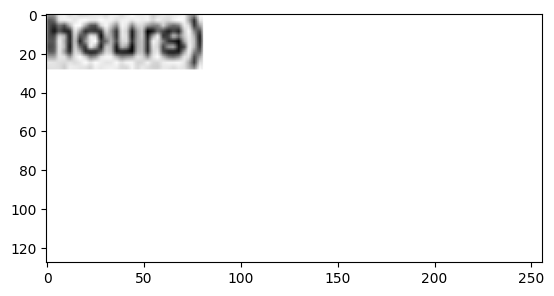

In [69]:
#Scales the width if the image to max_width. Only if the high after scaling to max_width is higher than max_hight, only the hight will be scaled down to max_hight
# Expacts gray scale Images
def preprocess(img):
    max_hight = 128
    max_width = 256

    (h, w) = img.shape


    #Scale all Images down that image width is max_width
    scaleFactor = max_width / w
    if scaleFactor < 1:
      img = cv2.resize(img, None, fx = scaleFactor, fy = scaleFactor)
      (h, w) = img.shape

    #creates blank white image with size max_hight x max_width
    final_img = np.ones([max_hight, max_width])*255 # blank white image

    # if hight is still greater than max_hight, scale only hight down to max_hight
    if h > max_hight:
       img = cv2.resize(img, None, fx = 1, fy = (max_hight/h))


    # fills the blank image with resized imput image
    final_img[:h, :w] = img
    return final_img

image = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
print(image.shape)

plt.imshow(preprocess(image),cmap='gray')

In [152]:
import json
import numpy as np

ImgFolder = '/content/drive/MyDrive/development/datasets/OCR_MNIST_Words/dataset/v011_words_small/'
imgPath = os.path.join(ImgFolder, "10.png")

with open('/content/drive/MyDrive/development/datasets/OCR_MNIST_Words/v011_labels_small.json') as f:
    data = json.load(f)

result = data.items()
data = list(result)
keyVal = np.array(data)
y_all = keyVal[:,1]
x_all_img_path = keyVal[:,0]
print(x_all_img_path)
print(y_all.size)

i = 0
for imgName in x_all_img_path:
  imgPath = os.path.join(ImgFolder, imgName)
  entry = cv2.imread(imgPath,cv2.IMREAD_GRAYSCALE)
  #print(entry)
  if i == 0:
    x_all = entry
  else:
    x_all = np.append(x_all,entry)

  print(type(x_all))
  #plt.imshow(x_all[i])
  #plt.show()
  i=i+1

  if i == 10:
    break



['0.jpeg' '1.jpeg' '2.jpeg' ... '9997.jpeg' '9998.jpeg' '9999.jpeg']
10000
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
